-------------------------------------------------------------------

- **Autor:** Renato Andrade Mosqueira Furtado
- **Orientadores:** André Luís Marques Marcato e Ivo Chaves da Silva Junior
- **e-mail:** renato.andrade@engenharia.ufjf.br
- **Objetivo:** formular genericamente um problema de otimização não-linear inteiro misto a fim de calcular a melhor ordem e os melhores coeficientes mensais para geração de séries sintéticas de afluência para qualquer usina ou Reservatório Equivalente de Energia do SIN.
-------------------------------------------------------------------

# **Instalação do PySDDP**

In [1]:
#!pip install PySDDP

In [2]:
!pip uninstall PySDDP

# **Importação do dados e bibliotecas**

- Leitura do deck de dados disponibilizados no site da CCEE na pasta alocada no drive do usuário. Deve-se, portanto, trocar a variável **CAMINHO** colocando o endereço de acesso à pasta.

In [3]:
from google.colab import drive
import os
import sys
from google.colab import files


drive.mount('/content/gdrive')

sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/Planejamento Energético')

print(os.getcwd())


#============== Usuário deve trocar aqui de acordo com a pasta utilizada no drive ================
Caminho = '/content/gdrive/MyDrive/Colab Notebooks/Planejamento Energético/Deck_JULHO_2024'
#=================================================================================================

sys.path

Mounted at /content/gdrive
/content


['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor',
 '/root/.ipython',
 '/content/gdrive/MyDrive/Colab Notebooks/Planejamento Energético']

In [4]:
from PySDDP.Pen import Newave
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from cvxopt import matrix,solvers
import time
import pickle
from sklearn.preprocessing import StandardScaler,normalize
import copy
from scipy.stats import skew,kurtosis

In [5]:
casoestudo = Newave(Caminho)

OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 102 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 1 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.


# **Algoritmo de Otimização Aritmética**

 - **Material adicional com mais detalhes sobre a meta-heurística**:
  - https://ieeexplore.ieee.org/abstract/document/10006248
  - https://www.sba.org.br/cba2022/wp-content/uploads/artigos_cba2022/paper_9772.pdf

 - **Parâmetros da função *AOA*:**
  - *mu:* parâmetro de atualização das variáveis da meta-heurística;
  - *alpha:* parâmetro utilizado indiretamente para atualização das variáveis na meta-heurística. Associado ao parâmetro **OMP** definido na função;
  - *epsilon:* número pequeno a fim de evitar divisão por zero nas atualizações;
  - *N_iter:* número total de iterações;
  - *N_solucoes:* número de possíveis soluções/indivíduos para o problema;
  - *AOM_min:* limite inferior do parâmetro AOM que é utilizado para definir o espaço de busca;
  - *AOM_max:* limite superior do parâmetro AOM que é utilizado para definir o espaço de busca;
  - *Tipo:* se UHE, o problema é resolvido para vazões de uma usina hidrelétrica do SIN; se REE, o problema é resolvido para Energia Natural Afluente (ENA) de um Reservatório Equivalente de Energia (REE) do SIN;
  - *Nome:* string relacionada ao nome da usina ou REE;
  - *Ordem:* ordem utilizada para calcular a vazão estimada;
  - *Ano_inicial:* ano a partir do qual se conhece as vazões e que será utilizado como equação de igualdade;
  -*Ano_final:* último ano no qual todas as vazões são conhecidas e que será utilizado como equação de igualdade;
  - *grafico:* se **True**, plota gráfico de convergência; se **False**, o gráfico não é plotado;
  - *flag_progresso:* se **True**, a FOB de cada iteração é mostrada; se **False**, convergência da FOB, ao longo das iterações, não é mostrada;
  - *flag_progresso_mes:* se **True**, avisa o final do processo iterativo para cada mês; se **False**, não avisa a finalização dos cálculos para os meses.


## Função

In [6]:
def AOA(mu,alpha,epsilon,N_iter,N_solucoes,AOM_min,AOM_max,Tipo,Nome,Ano_inicial,Ano_final,grafico,flag_progresso,flag_progresso_mes):

  #------------------ Dados de entrada ----------------------

  Tipo = Tipo
  Nome = Nome
  Ordem = 11
  Ano_inicial = Ano_inicial
  Ano_final = Ano_final

  Nr_anos = Ano_final - Ano_inicial + 1

  # PARÂMETROS DA METAHEURÍSTICA
  mu = mu
  alpha = alpha
  N_iter = N_iter
  N_solucoes = N_solucoes
  AOM_min = AOM_min
  AOM_max = AOM_max
  grafico = grafico
  flag_progresso = flag_progresso
  flag_progresso_mes = flag_progresso_mes

  if Tipo=='UHE':

    #---------------- Leitura da usina selecionada ------------

    uhe = casoestudo.confhd.get(Nome) # Nome_usina -> entrada pelo usuário

    dados_hist = np.array(uhe['vazoes'],dtype=float) # Acessa as vazões da usina em questão

    data_hist = pd.DataFrame(data=dados_hist,columns=['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro'],index = np.linspace(int(1931),int(np.size(dados_hist,0)+1931-1),np.size(dados_hist,0)))
    # Transforma em DataFrame no qual as colunas são os meses e as linhas os anos: 1931 - 2023

    #--------------- Criação de uma lista com meses -----------------------------

    mes_lista = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']


  elif Tipo=='REE':

    #---------------- Leitura do REE selecionado ------------

    ree = casoestudo.ree.get(Nome) # Nome_usina -> entrada pelo usuário

    dados_hist = np.array(np.transpose(ree['ena_bruta'][0]),dtype=float) # Acessa as ENAs do REE em questão

    data_hist = pd.DataFrame(data=dados_hist,columns=['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro'],index = np.linspace(int(1931),int(np.size(dados_hist,0)+1931-1),np.size(dados_hist,0)))
    # Transforma em DataFrame no qual as colunas são os meses e as linhas os anos: 1931 - 2023

    #--------------- Criação de uma lista com meses -----------------------------

    mes_lista = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']


  #--------------------------- Número do mês estimado ----------------------------------


  Melhor_ordem = dict()
  convergencia = dict() # dicionário referente à convergência do AOA para cada mês


  #=============================================================================================================
  #=========================== ÍNICIO DA OTIMIZAÇÃO ARITMÉTICA =================================================
  #=============================================================================================================

  inicio = time.time()

  for Mes_estimado in mes_lista:

    x_best = list()

    Nr_mes_estimado = mes_lista.index(Mes_estimado) + 1

    Melhor_ordem[Mes_estimado] = dict()
    convergencia[Mes_estimado] = np.zeros((2,N_iter+1))

    x_min = np.zeros((1,12)) # valor mínimo das variáveis
    x_max = np.zeros((1,12)) # valor máximo das variáveis

    # Ordem

    x_min[0][0] = 1
    x_max[0][0] = 11

    # Coeficientes

    x_min[0][1:np.size(x_min,1)] = 0.01
    x_max[0][1:np.size(x_max,1)] = 10

    N_variaveis = np.size(x_min,1) # número de colunas = número de variáveis

    iter = 0 # contador de iteracoes

    x_inicial = np.zeros((N_solucoes,N_variaveis))

    # Inicialização do conjunto solução

    for i in range(0,np.size(x_inicial,0)):
      for j in range(0,np.size(x_inicial,1)):
        if j!=0:
          x_inicial[i][j] = np.random.random()*x_max[0][j] # chute inicial para os parâmetros
        else:
          x_inicial[i][j] = np.random.randint(x_min[0][j],x_max[0][j]+1) # chute inicial para os parâmetros

      # correção devido à ordem

      x_inicial[i][1:int(11-x_inicial[i][0]+1)] = 0.


    x_sol = x_inicial.copy()
    x_sol_new = np.zeros((N_solucoes,N_variaveis))

    FOB = np.zeros((np.size(x_sol,0),1))
    FOB_new = np.zeros((np.size(x_sol,0),1))

    #-------------------- Montando a matriz de Vazões -------------------------

    A_hist = np.zeros((Nr_anos,11))

    for linha in range(0,Nr_anos):

      ano = Ano_inicial + linha # acessar o DataFrame

      coluna = 0

      for ord in range(Nr_mes_estimado - Ordem - 1,Nr_mes_estimado-1):

        if ord<0:

          ano_anterior = ano - 1

          mes_ano_anterior = 13 + ord

          A_hist[linha][coluna] = float(data_hist[mes_lista[mes_ano_anterior-1]][ano_anterior])

          coluna = coluna + 1

        else:

          A_hist[linha][coluna] = float(data_hist[mes_lista[ord]][ano])

          coluna = coluna + 1

    #---------------------- Vetor coluna das vazões do mês estimado ------------------------

    Var_mes_estimado = data_hist.loc[Ano_inicial:Ano_final,Mes_estimado]

    #---------------------- Inicialização da Função Objetivo -------------------------------

    for i in range(0,np.size(x_inicial,0)):

      Var_estimada = np.dot(A_hist,np.transpose(x_sol[i,1:np.size(x_sol,1)]))

      Erro = np.subtract(Var_mes_estimado,Var_estimada)

      Somatorio_erros = float(np.std(Erro))

      FOB[i][0] = Somatorio_erros

      #----------------------------------------------------------------------------------------

      if i==0:
        Best = FOB[i][0]
        linha = i
      elif FOB[i][0]<Best:
        Best = FOB[i][0]
        linha = i

    #----------------- Vetores para visualização da convergência -------------------

    x_label = np.zeros((1,N_iter+1))
    y_label = np.zeros((1,N_iter+1))

    #----------------- Inicialização dos vetores para plot -------------------------

    x_label[0][iter] = iter
    y_label[0][iter] = Best

    #====================================================================================================
    #====================================================================================================
    #==================================== PROCESSO ITERATIVO ============================================
    #====================================================================================================
    #====================================================================================================

    while iter<N_iter:

      iter = iter + 1

      AOM = AOM_min + (iter*(AOM_max - AOM_min)/N_iter) # Acelerador de Otimização Matemático
      OMP = 1 - ((iter**(1/alpha))/(N_iter**(1/alpha))) # Otimizador Matemático de Probabilidade

      x_best = x_sol[linha]

      for i in range(0,np.size(x_sol,0)):

        r1 = np.random.rand(1,np.size(x_sol,1)) # valor randômico do processo
        r2 = np.random.rand(1,np.size(x_sol,1)) # valor randômico do processo
        r3 = np.random.rand(1,np.size(x_sol,1)) # valor randômico do processo

        for j in range(0,np.size(x_sol,1)):

          if j!=0:
            #------------------------------ ESPAÇO DE BUSCA GLOBAL ---------------------------
            if r1[0][j]>AOM:
              if r2[0][j]>0.5:
                x_sol_new[i][j] = x_best[j]*OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j])
              else:
                x_sol_new[i][j] = x_best[j]/OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j])
            #------------------------------ ESPAÇO DE BUSCA LOCAL ---------------------------
            else:
              if r3[0][j]>0.5:
                x_sol_new[i][j] = x_best[j]+OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j])
              else:
                x_sol_new[i][j] = x_best[j]-OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j])

          else:

            #------------------------------ ESPAÇO DE BUSCA GLOBAL ---------------------------
            if r1[0][j]>AOM:
              if r2[0][j]>0.5:
                x_sol_new[i][j] = np.round(x_best[j]*OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j]))
              else:
                x_sol_new[i][j] = np.round(x_best[j]/OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j]))
            #------------------------------ ESPAÇO DE BUSCA LOCAL ---------------------------
            else:
              if r3[0][j]>0.5:
                x_sol_new[i][j] = np.round(x_best[j]+OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j]))
              else:
                x_sol_new[i][j] = np.round(x_best[j]-OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j]))


          #------------------------------ Penalizações ---------------------------

          if x_sol_new[i][j]>x_max[0][j] or x_sol_new[i][j]<x_min[0][j]:

            if j==0:

              x_sol_new[i][j] = np.round((x_max[0][j] + x_min[0][j])*np.random.random())

            else:

              x_sol_new[i][j] = (x_max[0][j])*np.random.random()


        # correção devido à ordem sub-ótima

        x_sol_new[i][1:int(11-x_sol_new[i][0]+1)] = 0.


        #-------------------------------- Cálculo da FOB para cada solução atualizada --------------------------

        Var_estimada = np.dot(A_hist,np.transpose(x_sol_new[i,1:np.size(x_sol_new,1)]))

        Erro = np.subtract(Var_mes_estimado,Var_estimada)

        Somatorio_erros = float(np.std(Erro))

        FOB_new[i][0] = Somatorio_erros

        #----------------------------------------------------------------------------------------

        if FOB_new[i][0]<FOB[i][0]:
          x_sol[i] = x_sol_new[i]
          FOB[i][0] = FOB_new[i][0]

      #-------------------------------- Determinação da melhor solução na iteração atual ----------------------

      for s in range(0,np.size(FOB,0)):
        if FOB[s][0]<Best:
          Best = FOB[s][0]
          linha = s

      x_label[0][iter] = iter
      y_label[0][iter] = Best

      if flag_progresso==True:
        print(f'Best(iter = {iter}) = {Best}')

    fim = time.time()

    #======================================= FIM DO PROCESSO ITERATIVO ==================================================

    x_best = x_sol[linha]
    convergencia[Mes_estimado][0,0:np.size(x_label,1)] = x_label[0,0:np.size(x_label,1)]
    convergencia[Mes_estimado][1,0:np.size(y_label,1)] = y_label[0,0:np.size(y_label,1)]

    # Coeficientes

    meses_coef = list()

    for ord in range(Nr_mes_estimado - 11 - 1,Nr_mes_estimado-1):

        if ord<0:

          mes_ano_anterior = 13 + ord

          meses_coef.append(mes_lista[mes_ano_anterior-1])

        else:

          meses_coef.append(mes_lista[ord])

    coeficientes = pd.DataFrame(data = [x_best[1:len(x_best)]],columns=meses_coef)

    # Comparação do valor real mensurado e estimado

    compara = 0

    Var_est = np.dot(A_hist,np.transpose(x_best[1:len(x_best)]))

    ano = [i for i in range(Ano_inicial,Ano_final+1)]

    if Tipo=='UHE':

      compara = pd.DataFrame(data = np.transpose([ano,Var_mes_estimado,Var_est,np.subtract(Var_mes_estimado,Var_est)]),columns = [' ','Valor real (m3/s)','Estimado (m3/s)','Erro (m3/s)'])

    elif Tipo=='REE':

      compara = pd.DataFrame(data = np.transpose([ano,Var_mes_estimado,Var_est,np.subtract(Var_mes_estimado,Var_est)]),columns = [' ','Valor real (MWmed)','Estimado (MWmed)','Erro (MWmed)'])

    compara.set_index(' ',inplace=True)

    Melhor_ordem[Mes_estimado]['Ordem'] = int(x_best[0])
    Melhor_ordem[Mes_estimado]['Coeficientes'] = coeficientes
    Melhor_ordem[Mes_estimado]['Erros'] = compara
    Melhor_ordem[Mes_estimado]['FOB'] = Best

    if flag_progresso_mes:

      print(f'Mês de {Mes_estimado} calculado')
      print('.......................................')

  fim = time.time()

  tempo = fim - inicio

  #========================== DATAFRAME COM TODOS OS MESES E RESPECTIVOS COEFICIENTES =====================

  Resultado_Final = np.zeros((12,13)) # 12 meses, 12 meses + 1 coluna da FOB

  for imes in mes_lista:

    for m in mes_lista:

      if imes==m:

        Resultado_Final[mes_lista.index(imes)][mes_lista.index(m)] = 0.

      else:

        Resultado_Final[mes_lista.index(imes)][mes_lista.index(m)] = round(Melhor_ordem[imes]['Coeficientes'][m][0],4)

    Resultado_Final[mes_lista.index(imes)][12] = round(Melhor_ordem[imes]['FOB'],4)

  if Tipo=='UHE':

    Resultado = pd.DataFrame(Resultado_Final,columns=mes_lista+['FOB [m3/s]'],index=mes_lista)

  elif Tipo=='REE':

    Resultado = pd.DataFrame(Resultado_Final,columns=mes_lista+['FOB [MWmed]'],index=mes_lista)

  print(f'Tempo total de execução = {tempo} s')

  #=============================== GRÁFICO DE CONVERGÊNCIA =============================

  cores = ['black','red','grey','darkorange','gold','green','blue','darkviolet','pink','deepskyblue','lime','chocolate']

  if grafico:

    if Tipo=='UHE':

      fig,axis = plt.subplots(figsize=(8,6))

      for imes in mes_lista:

        axis.plot(convergencia[imes][0,0:np.size(convergencia[imes],1)],convergencia[imes][1,0:np.size(convergencia[imes],1)],lw=2.0,label=imes[0:3],color = cores[mes_lista.index(imes)])

      axis.set_xlabel('Iteração')
      axis.set_ylabel('FOB $[m^3/s]$')
      axis.set_xlim([0,N_iter]);
      axis.legend(fontsize=8,ncol=4);
      plt.savefig('convergencia_AOA_'+Tipo+'_'+Nome+'.pdf',bbox_inches='tight');

    elif Tipo=='REE':

      fig,axis = plt.subplots(figsize=(8,6))

      for imes in mes_lista:

        axis.plot(convergencia[imes][0,0:np.size(convergencia[imes],1)],convergencia[imes][1,0:np.size(convergencia[imes],1)],lw=2.0,label=imes[0:3],color = cores[mes_lista.index(imes)])

      axis.set_xlabel('Iteração')
      axis.set_ylabel('FOB [MWmed]')
      axis.set_xlim([0,N_iter]);
      axis.legend(fontsize=8,ncol=4);
      plt.savefig('convergencia_AOA_'+Tipo+'_'+Nome+'.pdf',bbox_inches='tight');

  return Melhor_ordem,Resultado,convergencia,tempo


## Resultado

Mês de Janeiro calculado
.......................................
Mês de Fevereiro calculado
.......................................
Mês de Março calculado
.......................................
Mês de Abril calculado
.......................................
Mês de Maio calculado
.......................................
Mês de Junho calculado
.......................................
Mês de Julho calculado
.......................................
Mês de Agosto calculado
.......................................
Mês de Setembro calculado
.......................................
Mês de Outubro calculado
.......................................
Mês de Novembro calculado
.......................................
Mês de Dezembro calculado
.......................................
Tempo total de execução = 56.572954416275024 s


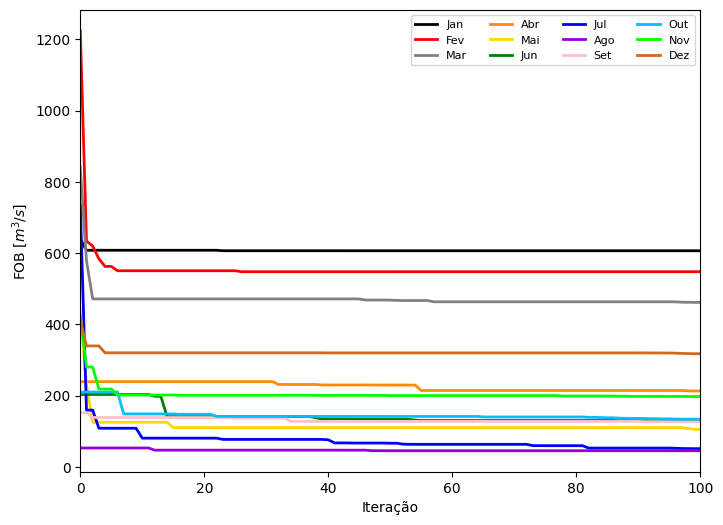

In [ ]:
solucao_AOA = AOA(mu=0.999,alpha=6.64,epsilon=0.000099,N_iter=100,N_solucoes=100,AOM_min=0.,AOM_max=1.,
                          Tipo='UHE',Nome='Furnas',Ano_inicial=1932,Ano_final=2022,
                          grafico=True,flag_progresso=False,flag_progresso_mes=True)

file_path = 'SOLUCAO_AOA_UHE_FURNAS.pkl'
with open(file_path, 'wb') as file:

    pickle.dump(solucao_AOA, file)

In [41]:
with open('SOLUCAO_AOA_UHE_FURNAS.pkl', 'rb') as f:
        solucao_AOA = pickle.load(f)

In [42]:
mes_lista = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']

In [43]:
for mes in mes_lista:

  ordem = solucao_AOA[0][mes]['Ordem']

  print(f'{mes} = {ordem}')

Janeiro = 1
Fevereiro = 1
Março = 2
Abril = 2
Maio = 4
Junho = 2
Julho = 3
Agosto = 1
Setembro = 3
Outubro = 4
Novembro = 2
Dezembro = 4


In [44]:
solucao_AOA[1]

,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro,FOB [m3/s]
Janeiro,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.8471,606.5406
Fevereiro,0.4420,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,547.7422
Março,0.1573,0.4373,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,461.6251
Abril,0.0000,0.1650,0.3754,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,212.7806
Maio,0.0455,0.0836,0.0977,0.2995,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,105.0971
Junho,0.0000,0.0000,0.0000,0.1494,0.6723,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,129.9547
Julho,0.0000,0.0000,0.0000,0.0462,0.2850,0.3163,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,50.9281
Agosto,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7418,0.0000,0.0000,0.0000,0.0000,0.0000,45.1583
Setembro,0.0000,0.0000,0.0000,0.0000,0.0000,0.3887,0.0535,0.6973,0.0000,0.0000,0.0000,0.0000,126.6460
Outubro,0.0000,0.0000,0.0000,0.0000,0.0000,0.2892,0.1951,0.0272,0.3788,0.0000,0.0000,0.0000,133.7582


# **PAR(p) - Box & Jenkins**

## Função

In [25]:
def box_jenkins(Tipo,Nome,Ano_inicial,Ano_final):

  Tipo = Tipo
  Nome = Nome
  Ano_inicial = Ano_inicial
  Ano_final = Ano_final

  #--------------------------------- DADOS HISTÓRICOS -----------------------------------------------------


  if Tipo=='UHE':

    #---------------- Leitura da usina selecionada ------------

    uhe = casoestudo.confhd.get(Nome) # Nome_usina -> entrada pelo usuário

    dados_hist = np.array(uhe['vazoes'],dtype=float) # Acessa as vazões da usina em questão

    data_hist = pd.DataFrame(data=dados_hist,columns=['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro'],index = np.linspace(int(1931),int(np.size(dados_hist,0)+1931-1),np.size(dados_hist,0)))
    # Transforma em DataFrame no qual as colunas são os meses e as linhas os anos: 1931 - 2023

    #--------------- Criação de uma lista com meses -----------------------------

    mes_lista = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']


  elif Tipo=='REE':

    #---------------- Leitura do REE selecionado ------------

    ree = casoestudo.ree.get(Nome) # Nome_usina -> entrada pelo usuário

    dados_hist = np.array(np.transpose(ree['ena_bruta'][0]),dtype=float) # Acessa as ENAs do REE em questão

    data_hist = pd.DataFrame(data=dados_hist,columns=['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro'],index = np.linspace(int(1931),int(np.size(dados_hist,0)+1931-1),np.size(dados_hist,0)))
    # Transforma em DataFrame no qual as colunas são os meses e as linhas os anos: 1931 - 2023

    #--------------- Criação de uma lista com meses -----------------------------

    mes_lista = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']

  #----------------------------------------------------------------------------------------------------------------------------



  # Cálculo da Função de Auto-Correlação (FAC)

  FAC = np.zeros((12,12))  # linhas = 12, porque são 12 lags, considerando o lag = 0... colunas = 12, porque são 12 meses

  for imes in range(1,13):

    for ilag in range(0,12):

      if ilag==0:

        FAC[imes-1][ilag] = 1

      else:

        if imes - ilag <=0:

          imes_anterior = imes - ilag + 12

        else:

          imes_anterior = imes - ilag

        mes = mes_lista[imes-1]
        mes_anterior = mes_lista[imes_anterior - 1]

        media_mes = np.mean(data_hist[mes].loc[Ano_inicial:Ano_final+1])
        desvio_mes = np.std(data_hist[mes].loc[Ano_inicial:Ano_final+1])

        media_mes_anterior = np.mean(data_hist[mes_anterior].loc[Ano_inicial:Ano_final+1])
        desvio_mes_anterior = np.std(data_hist[mes_anterior].loc[Ano_inicial:Ano_final+1])

        for iano in range(Ano_inicial,Ano_final+2):

          if imes-ilag<=0:

            FAC[imes-1][ilag] = FAC[imes-1][ilag] + (data_hist[mes][iano] - media_mes)*(data_hist[mes_anterior][iano-1] - media_mes_anterior)

          else:

            FAC[imes-1][ilag] = FAC[imes-1][ilag] + (data_hist[mes][iano] - media_mes)*(data_hist[mes_anterior][iano] - media_mes_anterior)

        FAC[imes-1][ilag] = FAC[imes-1][ilag]/(Ano_final - Ano_inicial + 1 + 1)

        FAC[imes-1][ilag] = FAC[imes-1][ilag]/(desvio_mes*desvio_mes_anterior)

  # Cálculo da Função de Auto-Correlação Parcial (FACP)

  FACP = np.zeros((12,11))

  for imes in range(1,13):

    for ilag in range(1,12):

      A = np.zeros((ilag,ilag))
      b = np.zeros((ilag,1))

      for i in range(1,ilag+1):

        for j in range(1,ilag+1):

          if j<i:

            lag = i-j
            qtd_meses_anteriores = j

            if imes - qtd_meses_anteriores<=0:

              mes = imes - qtd_meses_anteriores + 12

            else:

              mes = imes - qtd_meses_anteriores

            A[i-1][j-1] = FAC[mes-1][lag]

          elif i==j:

            A[i-1][j-1] = 1

          else:

            lag = j-i
            qtd_meses_anteriores = i

            if imes - qtd_meses_anteriores<=0:

              mes = imes - qtd_meses_anteriores + 12

            else:

              mes = imes - qtd_meses_anteriores

            A[i-1][j-1] = FAC[mes-1][lag]

        b[i-1][0] = FAC[imes-1][i]

      facp = np.linalg.solve(A,b)

      FACP[imes-1][ilag-1] = float(facp[ilag-1][0])

  # Cálculo das ordens

  IC = 1.96/np.sqrt((Ano_final - Ano_inicial + 2))

  ordem = []

  for imes in range(1,13):

    lag_max = 0

    for ilag in range(1,12):

      if FACP[imes-1][ilag-1] < -IC or FACP[imes-1][ilag-1] > IC:

        lag_max = ilag

    ordem.append(lag_max)

  # Definição dos coeficientes

  coefs = np.zeros((12,11))

  for imes in range(1,13):

    ordem_imes = ordem[imes-1]

    A = np.zeros((ordem_imes,ordem_imes))
    b = np.zeros((ordem_imes,1))

    for i in range(1,ordem_imes+1):

      for j in range(1,ordem_imes+1):

        if j<i:

          lag = i-j
          qtd_meses_anteriores = j

          if imes - qtd_meses_anteriores<=0:

            mes = imes - qtd_meses_anteriores + 12

          else:

            mes = imes - qtd_meses_anteriores

          A[i-1][j-1] = FAC[mes-1][lag]

        elif i==j:

          A[i-1][j-1] = 1

        else:

          lag = j-i
          qtd_meses_anteriores = i

          if imes - qtd_meses_anteriores<=0:

            mes = imes - qtd_meses_anteriores + 12

          else:

            mes = imes - qtd_meses_anteriores

          A[i-1][j-1] = FAC[mes-1][lag]

      b[i-1][0] = FAC[imes-1][i]

    coefs[imes-1,0:ordem_imes] = np.linalg.solve(A,b)[0:ordem_imes,0]

  #===========================================================================
  #======================= RESULTADOS FINAIS =================================
  #===========================================================================

  Melhor_ordem = dict()

  for imes in range(1,13):

    # Coeficientes

    Nr_mes_estimado = imes

    Mes_estimado = mes_lista[imes-1]

    Melhor_ordem[Mes_estimado] = dict()

    meses_coef = list()

    for ord in range(Nr_mes_estimado - 11 - 1,Nr_mes_estimado-1):

        if ord<0:

          mes_ano_anterior = 13 + ord

          meses_coef.append(mes_lista[mes_ano_anterior-1])

        else:

          meses_coef.append(mes_lista[ord])

    coeficientes = pd.DataFrame(data = [list(coefs[imes-1,0:12])[::-1]],columns=meses_coef)

    # Comparação do valor real mensurado e estimado

    compara = 0

    A_hist = np.zeros((Ano_final - Ano_inicial + 1,11))

    Var_mes_estimado = list()

    for iano in range(Ano_inicial,Ano_final+1):

      contador = 0

      for iordem in range(Nr_mes_estimado-11-1,Nr_mes_estimado-1):

        if iordem<0:

          mes_ano_anterior = 13 + iordem

          A_hist[iano-1931-1][contador] = data_hist[mes_lista[mes_ano_anterior-1]][iano-1]

          contador = contador + 1

        else:

          A_hist[iano-1931-1][contador] = data_hist[mes_lista[iordem]][iano]

          contador = contador + 1

      Var_mes_estimado.append(data_hist[mes_lista[imes-1]][iano])

    Var_est = np.dot(A_hist,np.transpose(list(coefs[imes-1,0:12])[::-1]))

    ano = [i for i in range(Ano_inicial,Ano_final+1)]

    if Tipo=='UHE':

      compara = pd.DataFrame(data = np.transpose([ano,Var_mes_estimado,Var_est,np.subtract(Var_mes_estimado,Var_est)]),columns = [' ','Valor real (m3/s)','Estimado (m3/s)','Erro (m3/s)'])

    elif Tipo=='REE':

      compara = pd.DataFrame(data = np.transpose([ano,Var_mes_estimado,Var_est,np.subtract(Var_mes_estimado,Var_est)]),columns = [' ','Valor real (MWmed)','Estimado (MWmed)','Erro (MWmed)'])

    compara.set_index(' ',inplace=True)

    Melhor_ordem[Mes_estimado]['Ordem'] = ordem[imes-1]
    Melhor_ordem[Mes_estimado]['Coeficientes'] = coeficientes
    Melhor_ordem[Mes_estimado]['Erros'] = compara

 #========================== DATAFRAME COM TODOS OS MESES E RESPECTIVOS COEFICIENTES =====================

  Resultado_Final = np.zeros((12,12)) # 12 meses, 12 meses + 1 coluna da FOB

  for imes in mes_lista:

    for m in mes_lista:

      if imes==m:

        Resultado_Final[mes_lista.index(imes)][mes_lista.index(m)] = 0.

      else:

        Resultado_Final[mes_lista.index(imes)][mes_lista.index(m)] = round(Melhor_ordem[imes]['Coeficientes'][m][0],4)

  if Tipo=='UHE':

    Resultado = pd.DataFrame(Resultado_Final,columns=mes_lista,index=mes_lista)

  elif Tipo=='REE':

    Resultado = pd.DataFrame(Resultado_Final,columns=mes_lista,index=mes_lista)

  return Melhor_ordem,Resultado

## Resultado

In [45]:
solucao_parp = box_jenkins('UHE','FURNAS',1932,2022)

# **Séries Sintéticas**

## **Criação das Séries Sintéticas**

- **Dados de entrada preenchidos pelo usuário:**
 - *Tipo_Tendencia:* COM ou SEM. Se variável for "COM", as séries sintéticas geradas serão com tendência hidrológica. Caso a variávela seja "SEM", não é considerada a tendência hidrológica;
 - *Tipo:* UHE ou REE;
 - *Nome_usina*: deve-se colocar o nome da usina ou do REE o qual o usuário deseja estudar;
 - *Melhor_ordem*: corresponde à primeira posição do vetor de resultados advindos da otimização aritmética;
 - *Ano_inicial_horizonte*: variável que indica o último ano será feito o cálculo das séries;
 - *Mes_inicial*: variável que indica a partir de qual mês será feito o cálculo das séries;
  - *Horizonte*: variável que indica o horizonte de planejamento em anos;
  - *Nr_series*: variável que indica o número de séries que se deseja gerar;
  - *Ano_Atual*: variável que indica o ano atual;
  - *grafico*: variável condicional referente à plotagem de gráfico (**True**) ou não plotagem (**False**).

### Função

In [46]:
def series_sinteticas(Tipo_Tendencia,Tipo,Nome_usina,Melhor_ordem,Ano_inicial_horizonte,Mes_inicial,Horizonte,Nr_series,Ano_Atual,grafico):

  #------------------ Dados de entrada ----------------------

  Tipo_Tendencia = Tipo_Tendencia
  Tipo = Tipo
  Nome_usina = Nome_usina
  Melhor_ordem = Melhor_ordem
  Ano_inicial_horizonte = Ano_inicial_horizonte
  Nr_series = Nr_series
  Horizonte = Horizonte
  Mes_inicial = Mes_inicial
  Ano_Atual = Ano_Atual
  grafico=grafico

  Ano_final_horizonte = Ano_inicial_horizonte + Horizonte  # mudei aqui (-1)

  if Tipo=='UHE':

    #---------------- Leitura da usina selecionada ------------

    uhe = casoestudo.confhd.get(Nome_usina) # Nome_usina -> entrada pelo usuário

    vazoes = np.array(uhe['vazoes'],dtype=float) # Acessa as vazões da usina em questão

    data_vazoes = pd.DataFrame(data=vazoes,columns=['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro'],index = np.linspace(int(1931),int(Ano_Atual),Ano_Atual-1931+1))
    # Transforma em DataFrame no qual as colunas são os meses e as linhas os anos: 1931 - 2023

  elif Tipo=='REE':

    #---------------- Leitura do REE selecionado ------------

    ree = casoestudo.ree.get(Nome_usina) # Nome_usina -> entrada pelo usuário

    ena_bruta = np.array(np.transpose(ree['ena_bruta'][0]),dtype=float) # Acessa as ENAs do REE em questão

    data_vazoes = pd.DataFrame(data=ena_bruta,columns=['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro'],index = np.linspace(int(1931),int(Ano_Atual),Ano_Atual-1931+1))
    # Transforma em DataFrame no qual as colunas são os meses e as linhas os anos: 1931 - 2023

  #--------------- Criação de uma lista com meses -----------------------------

  mes_lista = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']

  # mudei aqui # (Horizonte - 1) ---> (Horizonte)

  Serie_sintetica = pd.DataFrame(data = np.zeros((Horizonte,12)),columns=['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro'],index=np.linspace(Ano_Atual+1,Ano_final_horizonte,Horizonte))

  Serie_sintetica = pd.concat([data_vazoes,Serie_sintetica])

  #-------------- Meses a serem passados em cada ano --------------------------

  pote_meses = dict()

  for ano in range(Ano_Atual,Ano_final_horizonte+1):

    pote_meses[str(ano)] = list()

    if ano==Ano_Atual:

      for m in range(mes_lista.index(Mes_inicial),mes_lista.index('Dezembro')+1):

        pote_meses[str(ano)].append(mes_lista[m])

    elif ano>Ano_Atual and ano<Ano_final_horizonte:

      for m in range(mes_lista.index('Janeiro'),mes_lista.index('Dezembro')+1):

        pote_meses[str(ano)].append(mes_lista[m])

    elif ano==Ano_final_horizonte:

      for m in range(mes_lista.index('Janeiro'),mes_lista.index(Mes_inicial)):

        pote_meses[str(ano)].append(mes_lista[m])


  #===============================================================================
  #===============================================================================
  #========================= INÍCIO DO CÁLCULO DAS SÉRIES ========================
  #===============================================================================
  #===============================================================================

  if Tipo_Tendencia.upper()=='COM':

    Serie_sintetica_k = dict() # dicionário que irá receber uma cópia do DataFrame "Serie_sintetica" para mudar de acordo
                              # com cada série sorteada

    for s in range(1,Nr_series+1):

      Serie_sintetica_k[str(s)] = Serie_sintetica.copy()

      for a in range(Ano_Atual,Ano_final_horizonte+1):

        for m in pote_meses[str(a)]:

          ordem_otima = 11
          coef_otimos = np.array(list(Melhor_ordem[m]['Coeficientes'].loc[0]))

          MesCalculado = mes_lista.index(m)+1 # número do mês, Exemplo - Maio = 5
          EnderecoMesInicial = MesCalculado - ordem_otima - 1 # pode dar número negativo

          # vazões históricas

          vaz_hist = list()

          for k in range(EnderecoMesInicial,MesCalculado-1):

            if k<0:

              ano_analisado = a - 1 # ano anterior

              nome_mes_analisado = mes_lista[12+k]

              vaz_hist.append(Serie_sintetica_k[str(s)][nome_mes_analisado][ano_analisado])

            else:

              ano_analisado = a  # mesmo ano

              nome_mes_analisado = mes_lista[k]

              vaz_hist.append(Serie_sintetica_k[str(s)][nome_mes_analisado][ano_analisado])

          vaz_hist = np.transpose(np.array(vaz_hist))

          # sorteio do erro

          if Tipo=='UHE':

            lista_anos_validos = list(Melhor_ordem[m]['Erros'].loc[((Melhor_ordem[m]['Erros']['Erro (m3/s)']>=0.0) | (Melhor_ordem[m]['Erros']['Erro (m3/s)']<0.0))].index)

          elif Tipo=='REE':

            lista_anos_validos = list(Melhor_ordem[m]['Erros'].loc[((Melhor_ordem[m]['Erros']['Erro (MWmed)']>=0.0) | (Melhor_ordem[m]['Erros']['Erro (MWmed)']<0.0))].index)

          vaz_estimada = -1 # começo os sorteios dos erros

          indice_sorteado = np.random.randint(0,len(lista_anos_validos),1)[0]

          ano_sorteado = lista_anos_validos[indice_sorteado]

          if Tipo=='UHE':

            erro_sorteado = Melhor_ordem[m]['Erros']['Erro (m3/s)'][ano_sorteado]

          elif Tipo=='REE':

            erro_sorteado = Melhor_ordem[m]['Erros']['Erro (MWmed)'][ano_sorteado]

          if erro_sorteado<0:

            if Tipo=='UHE':

              multiplicativo = Melhor_ordem[m]['Erros']['Valor real (m3/s)'][ano_sorteado]/Melhor_ordem[m]['Erros']['Estimado (m3/s)'][ano_sorteado]

            elif Tipo=='REE':

              multiplicativo = Melhor_ordem[m]['Erros']['Valor real (MWmed)'][ano_sorteado]/Melhor_ordem[m]['Erros']['Estimado (MWmed)'][ano_sorteado]

            vaz_estimada = np.dot(coef_otimos,vaz_hist)*multiplicativo

          else:

            #-------- Multiplicação dos coeficientes pelas vazões históricas ou estimadas -------------------

            vaz_estimada = np.dot(coef_otimos,vaz_hist) + erro_sorteado

          Serie_sintetica_k[str(s)][m][a] = vaz_estimada


  elif Tipo_Tendencia.upper()=='SEM':

    for imes in list(Serie_sintetica.columns): # Calcula MLT Mensal

      Serie_sintetica[imes].loc[1931:Ano_Atual] = np.mean(Serie_sintetica[imes].loc[1931:Ano_Atual-1])

    Serie_sintetica_k = dict() # dicionário que irá receber uma cópia do DataFrame "Serie_sintetica" para mudar de acordo
                              # com cada série sorteada

    for etapa in range(1,3): # etapa 1 -> inicia com MLT
                             # etapa 2 -> aplica o final da série no início

      for s in range(1,Nr_series+1):

        if etapa==1:

          Serie_sintetica_k[str(s)] = Serie_sintetica.copy()

        elif etapa==2:

          for ordem in range(1,12):

            imes_anterior = mes_lista.index(Mes_inicial) + 1 - ordem

            if imes_anterior<=0:

              imes_anterior = imes_anterior + 12

              mes_anterior = mes_lista[imes_anterior - 1]

              Serie_sintetica_k[str(s)][mes_anterior][Ano_inicial_horizonte-1] = Serie_sintetica_k[str(s)][mes_anterior][Ano_final_horizonte-1]

            else:

              mes_anterior = mes_lista[imes_anterior - 1]

              Serie_sintetica_k[str(s)][mes_anterior][Ano_inicial_horizonte] = Serie_sintetica_k[str(s)][mes_anterior][Ano_final_horizonte]

        for a in range(Ano_Atual,Ano_final_horizonte+1):

          for m in pote_meses[str(a)]:

            ordem_otima = 11
            coef_otimos = np.array(list(Melhor_ordem[m]['Coeficientes'].loc[0]))

            MesCalculado = mes_lista.index(m)+1 # número do mês, Exemplo - Maio = 5
            EnderecoMesInicial = MesCalculado - ordem_otima - 1 # pode dar número negativo

            # vazões históricas

            vaz_hist = list()

            for k in range(EnderecoMesInicial,MesCalculado-1):

              if k<0:

                ano_analisado = a - 1 # ano anterior

                nome_mes_analisado = mes_lista[12+k]

                vaz_hist.append(np.mean(Serie_sintetica_k[str(s)][nome_mes_analisado][ano_analisado]))

              else:

                ano_analisado = a  # mesmo ano

                nome_mes_analisado = mes_lista[k]

                vaz_hist.append(Serie_sintetica_k[str(s)][nome_mes_analisado][ano_analisado])

            vaz_hist = np.transpose(np.array(vaz_hist))

            # sorteio do erro

            if Tipo=='UHE':

              lista_anos_validos = list(Melhor_ordem[m]['Erros'].loc[((Melhor_ordem[m]['Erros']['Erro (m3/s)']>=0.0) | (Melhor_ordem[m]['Erros']['Erro (m3/s)']<0.0))].index)

            elif Tipo=='REE':

              lista_anos_validos = list(Melhor_ordem[m]['Erros'].loc[((Melhor_ordem[m]['Erros']['Erro (MWmed)']>=0.0) | (Melhor_ordem[m]['Erros']['Erro (MWmed)']<0.0))].index)

            vaz_estimada = -1 # começo os sorteios dos erros

            indice_sorteado = np.random.randint(0,len(lista_anos_validos),1)[0]

            ano_sorteado = lista_anos_validos[indice_sorteado]

            if Tipo=='UHE':

              erro_sorteado = Melhor_ordem[m]['Erros']['Erro (m3/s)'][ano_sorteado]

            elif Tipo=='REE':

              erro_sorteado = Melhor_ordem[m]['Erros']['Erro (MWmed)'][ano_sorteado]

            if erro_sorteado<0:

              if Tipo=='UHE':

                multiplicativo = Melhor_ordem[m]['Erros']['Valor real (m3/s)'][ano_sorteado]/Melhor_ordem[m]['Erros']['Estimado (m3/s)'][ano_sorteado]

              elif Tipo=='REE':

                multiplicativo = Melhor_ordem[m]['Erros']['Valor real (MWmed)'][ano_sorteado]/Melhor_ordem[m]['Erros']['Estimado (MWmed)'][ano_sorteado]

              vaz_estimada = np.dot(coef_otimos,vaz_hist)*multiplicativo

            else:

              #-------- Multiplicação dos coeficientes pelas vazões históricas ou estimadas -------------------

              vaz_estimada = np.dot(coef_otimos,vaz_hist) + erro_sorteado

            Serie_sintetica_k[str(s)][m][a] = vaz_estimada




  #----------------------- Gráfico -------------------------------------------

  meses = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']

  if grafico==True:

    #------------------- MÉDIAS DADOS HISTÓRICOS ------------------

    media_dados_hist = list()
    desvio_dados_hist = list()

    for m in meses:

      media_dados_hist.append(np.mean(list(data_vazoes.loc[1931:Ano_Atual-1,m])))
      desvio_dados_hist.append(np.std(list(data_vazoes.loc[1931:Ano_Atual-1,m])))

    media_dados_hist = media_dados_hist*(Horizonte+1)
    desvio_dados_hist = desvio_dados_hist*Horizonte*(Horizonte+1)

    media_dados_hist = media_dados_hist[mes_lista.index(Mes_inicial):mes_lista.index(Mes_inicial) + Horizonte*12]
    desvio_dados_hist = desvio_dados_hist[mes_lista.index(Mes_inicial):mes_lista.index(Mes_inicial) + Horizonte*12]

    desvio_dados_hist_UP = list()
    desvio_dados_hist_DOWN = list()

    for k in range(0,len(desvio_dados_hist)):

      desvio_dados_hist_UP.append(media_dados_hist[k] + desvio_dados_hist[k])
      desvio_dados_hist_DOWN.append(media_dados_hist[k] - desvio_dados_hist[k])

    #--------------------------------------------------------------

    serie = dict()

    for s in range(1,Nr_series+1):

      serie[str(s)] = list()

      for ano in range(Ano_Atual,Ano_final_horizonte+1):

        if ano==Ano_Atual:

          for mes in range(mes_lista.index(Mes_inicial),len(mes_lista)):

              m = mes_lista[mes]

              serie[str(s)].append(Serie_sintetica_k[str(s)].loc[ano,m])

        elif ano>Ano_Atual and ano<Ano_final_horizonte:

          for mes in mes_lista:

            serie[str(s)].append(Serie_sintetica_k[str(s)].loc[ano,mes])

        elif ano==Ano_final_horizonte:

          for mes in range(0,mes_lista.index(Mes_inicial)):

              m = mes_lista[mes]

              serie[str(s)].append(Serie_sintetica_k[str(s)].loc[ano,m])


    #--------------------------------------------------------------
    media_mensal_series = list()
    desvio_mensal_series_UP = list()
    desvio_mensal_series_DOWN = list()

    for m in range(0,Horizonte*12):

      valores_mensais_series = list()

      valores_mensais_series = [serie[str(s)][m] for s in range(1,Nr_series+1)]

      media_mensal_series.append(np.mean(valores_mensais_series))

      desvio = np.abs(np.std(valores_mensais_series))

      desvio_mensal_series_UP.append(np.mean(valores_mensais_series)+desvio)

      desvio_mensal_series_DOWN.append(np.mean(valores_mensais_series)-desvio)

    #---------------------------------------------------------------------------

    # PLOTAGEM DE GRÁFICOS

    fig,axis = plt.subplots(figsize=(10,6))

    xlabel = np.linspace(1,Horizonte*12,Horizonte*12)

    meses_xlabel = ['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']*(Horizonte+1)

    meses_xaxis = []

    for m in range(mes_lista.index(Mes_inicial),mes_lista.index(Mes_inicial) + Horizonte*12):

      meses_xaxis.append(meses_xlabel[m])

    ano = Ano_Atual
    for m in range(0,len(meses_xaxis)):

      if meses_xaxis[m][0]=='J' and meses_xaxis[m-1][0]=='D' and m!=0:

        ano = ano + 1

      ano_str = str(ano)[2:]

      meses_xaxis[m] = meses_xaxis[m][0:3]+'/'+ano_str

    for s in range(1,Nr_series+1):

      if s==1:
        axis.plot(xlabel,serie[str(s)],color='lightgrey',lw=1.5,label=f'Séries sintéticas = {Nr_series}')
      else:
        axis.plot(xlabel,serie[str(s)],color='lightgrey',lw=1.5)

      plt.xticks(np.arange(1,Horizonte*12+1,1),meses_xaxis,rotation=90,fontsize=8.0)
      axis.set_xlabel('Horizonte')

      if Tipo=='UHE':

        axis.set_ylabel('Vazão [$m^3$/s]')

      elif Tipo=='REE':

        axis.set_ylabel('Energia Natural Afluente [MWmed]')

    axis.legend();

    for m in range(0,Horizonte*12):

      if m==0:
        axis.plot(xlabel,media_mensal_series,marker = '.',markersize = 3.0,color='darkblue',lw=5.5,label='Média das séries')
        axis.plot(xlabel,desvio_mensal_series_UP,marker='.',color='green',lw=5.5,label='Média +- Desvio Padrão (Séries)')
        axis.plot(xlabel,desvio_mensal_series_DOWN,marker='.',color='green',lw=5.5)
      else:
        axis.plot(xlabel,media_mensal_series,marker='.',markersize = 3.0,color='darkblue',lw=5.5)
        axis.plot(xlabel,desvio_mensal_series_UP,marker='.',color='green',lw=5.5)
        axis.plot(xlabel,desvio_mensal_series_DOWN,marker='.',color='green',lw=5.5)

    axis.legend();

    axis.plot(xlabel,media_dados_hist,color='deepskyblue',marker = '*',label='Média dos dados históricos',lw=1.5)
    axis.plot(xlabel,desvio_dados_hist_UP,color='lightgreen',marker = '*',label='Média +- Desvio Padrão (Histórico)',lw=1.5)
    axis.plot(xlabel,desvio_dados_hist_DOWN,color='lightgreen',marker = '*',lw=1.5)

    axis.legend(loc='upper left');

    axis.set_xlim([0,Horizonte*12+1])

    #plt.grid();

    nome_figura = Tipo+'_'+Nome_usina

    plt.savefig(nome_figura+'.pdf', bbox_inches='tight');

  return Serie_sintetica_k

### Resultados

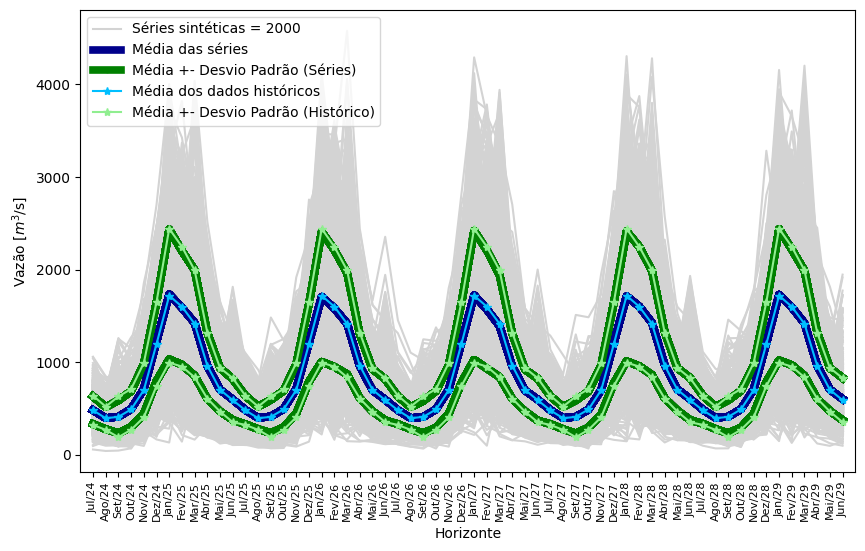

In [47]:
series = series_sinteticas(Tipo_Tendencia='SEM',Tipo='UHE',Nome_usina='FURNAS',Melhor_ordem=solucao_AOA[0],Ano_inicial_horizonte=2024,Mes_inicial='Julho',Horizonte=5,Nr_series=2000,Ano_Atual=2024,grafico=True)

# **Análise Estatística**

In [48]:
Tipo = 'UHE'
Nome = 'FURNAS'
Mes = 'Julho'

## Função

In [49]:
def analise_estatistica(Tipo,nome,Mes_inicial,Ano_inicial,Ano_final,nr_meses_horizonte,nr_series):

  Tipo = Tipo
  nome = nome
  Mes_inicial = Mes_inicial
  Ano_inicial = Ano_inicial
  Ano_final = Ano_final
  nr_meses_horizonte = nr_meses_horizonte
  nr_series = nr_series

  #============================ ASSIMETRIA e CURTOSE ===================================

  if Tipo=='UHE':

    dados = casoestudo.confhd.get(nome)

    assimetria_historia = []
    curtose_historia = []

    for imes in range(1,13):

      assimetria_historia.append(skew(dados['vazoes'][1932-1931:(Ano_final-2)-1931+1,imes-1]))
      curtose_historia.append(kurtosis(dados['vazoes'][1932-1931:(Ano_final-2)-1931+1,imes-1]))

    assimetria_series = []
    curtose_series = []

    meses = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']

    meses_horizonte = meses*(Ano_final - Ano_inicial + 1 + 1)

    imes_inicial = meses.index(Mes_inicial)

    meses_horizonte = meses_horizonte[imes_inicial:imes_inicial + nr_meses_horizonte]
    xlabel = []

    ano_inicial = Ano_inicial
    contador_ano = 0

    for imes in range(0,nr_meses_horizonte):

      if imes!=0:

        if meses_horizonte[imes]=='Janeiro' and meses_horizonte[imes-1]=='Dezembro':

          contador_ano = contador_ano + 1

      xlabel.append(meses_horizonte[imes][0:3]+'/'+str(ano_inicial+contador_ano)[2:4])

      valores_series = []

      for s in range(1,nr_series + 1):

        valores_series.append(series[str(s)][meses_horizonte[imes]][ano_inicial + contador_ano])

      assimetria_series.append(skew(valores_series))
      curtose_series.append(kurtosis(valores_series))

    assimetria_historia = assimetria_historia*(Ano_final - Ano_inicial + 1 + 1) # correção da assimetria histórica
    assimetria_historia = assimetria_historia[imes_inicial:imes_inicial+nr_meses_horizonte]

    curtose_historia = curtose_historia*(Ano_final - Ano_inicial + 1 + 1) # correção da assimetria histórica
    curtose_historia = curtose_historia[imes_inicial:imes_inicial+nr_meses_horizonte]

  elif Tipo=='REE':

    dados = casoestudo.ree.get(nome)

    assimetria_historia = []
    curtose_historia = []

    for imes in range(1,13):

      assimetria_historia.append(skew(np.transpose(dados['ena_bruta'][0])[1932-1931:(Ano_final-2)-1931+1,imes-1]))
      curtose_historia.append(kurtosis(np.transpose(dados['ena_bruta'][0])[1932-1931:(Ano_final-2)-1931+1,imes-1],fisher=True))

    assimetria_series = []
    curtose_series = []

    meses = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']

    meses_horizonte = meses*(Ano_final - Ano_inicial + 1 + 1)

    imes_inicial = meses.index(Mes_inicial)

    meses_horizonte = meses_horizonte[imes_inicial:imes_inicial + nr_meses_horizonte]
    xlabel = []

    contador_ano = 0
    ano_inicial = Ano_inicial
    for imes in range(0,nr_meses_horizonte):

      if imes!=0:

        if meses_horizonte[imes]=='Janeiro' and meses_horizonte[imes-1]=='Dezembro':

          contador_ano = contador_ano + 1

      xlabel.append(meses_horizonte[imes][0:3]+'/'+str(ano_inicial+contador_ano)[2:4])

      valores_series = []

      for s in range(1,nr_series + 1):

        valores_series.append(series[str(s)][meses_horizonte[imes]][ano_inicial + contador_ano])

      assimetria_series.append(skew(valores_series))
      curtose_series.append(kurtosis(valores_series,fisher=True))

    assimetria_historia = assimetria_historia*(Ano_final - Ano_inicial + 1 + 1) # correção da assimetria histórica
    assimetria_historia = assimetria_historia[imes_inicial:imes_inicial+nr_meses_horizonte]

    curtose_historia = curtose_historia*(Ano_final - Ano_inicial + 1 + 1) # correção da assimetria histórica
    curtose_historia = curtose_historia[imes_inicial:imes_inicial+nr_meses_horizonte]

  fig,axis = plt.subplots(figsize=(10,6))

  axis.plot(xlabel,assimetria_historia,color='red',marker='o',label='Assimetria histórica')
  axis.plot(xlabel,assimetria_series,color='blue',marker='o',label='Assimetria séries sintéticas')
  axis.plot(xlabel,np.zeros((nr_meses_horizonte)),color='black',ls='--',label='Referência')
  plt.xticks(np.arange(0,60,1),xlabel,rotation=90,fontsize=8.0);
  axis.set_xlabel('Meses');
  axis.set_ylabel('Coeficiente de Assimetria')
  axis.legend();
  plt.savefig('assimetria_'+Tipo+'_'+nome+'.pdf',bbox_inches='tight');

  fig,axis = plt.subplots(figsize=(10,6))

  axis.plot(xlabel,curtose_historia,color='red',marker='o',label='Curtose histórica')
  axis.plot(xlabel,curtose_series,color='blue',marker='o',label='Curtose séries sintéticas')
  axis.plot(xlabel,0*np.zeros((nr_meses_horizonte)),color='black',ls='--',label='Referência')
  plt.xticks(np.arange(0,60,1),xlabel,rotation=90,fontsize=8.0);
  axis.set_xlabel('Meses');
  axis.set_ylabel('Coeficiente de Curtose')
  axis.legend();
  plt.savefig('curtose_'+Tipo+'_'+nome+'.pdf',bbox_inches='tight');


## Resultado

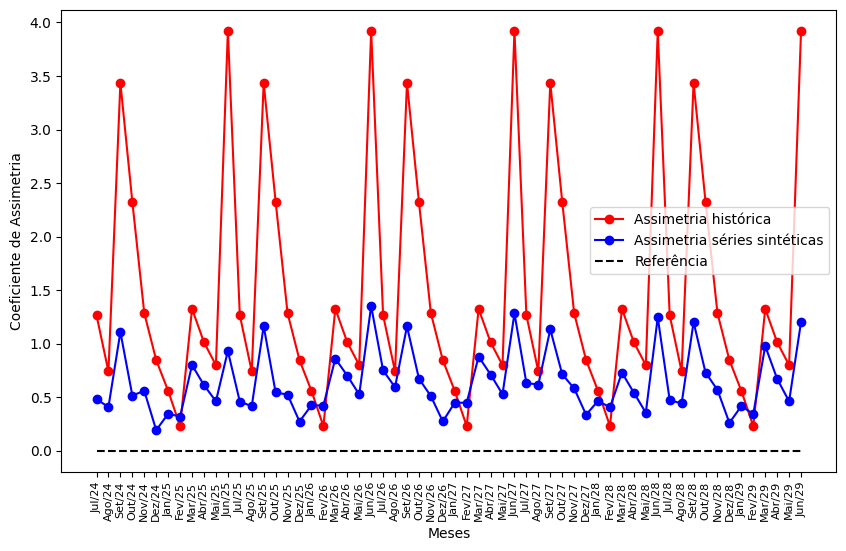

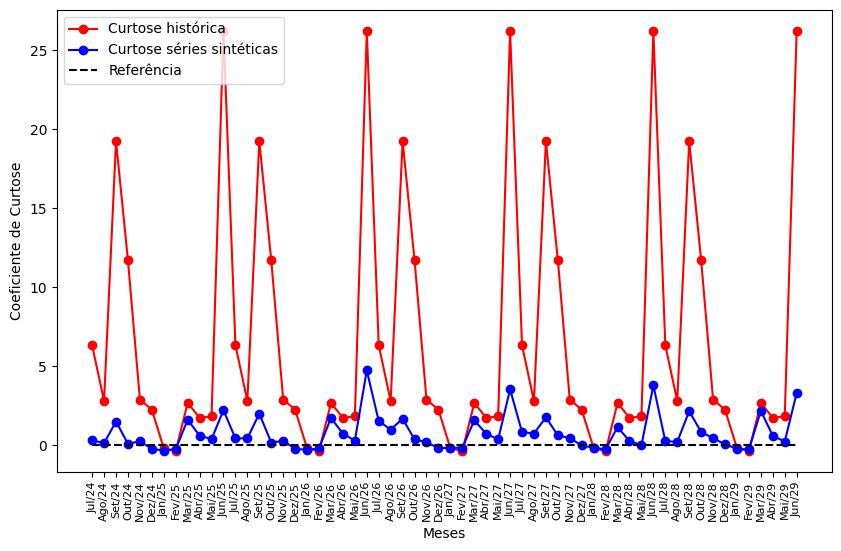

In [50]:
analise_estatistica(Tipo,Nome,Mes,2024,2029,60,2000)

## Compara Erro PARp

### Erro

In [ ]:
meses = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']

In [ ]:
if Tipo=='REE':
  media_erro_parp = [np.sqrt(np.sum(np.square(solucao_parp[0][imes]['Erros']['Erro (MWmed)']))/(2022-1932+1)) for imes in meses]
  media_erro_AOA = [np.sqrt(np.sum(np.square(solucao_AOA[0][imes]['Erros']['Erro (MWmed)']))/(2022-1932+1)) for imes in meses]
  desvio_erro_parp = [np.std(solucao_parp[0][imes]['Erros']['Erro (MWmed)']) for imes in meses]
  desvio_erro_AOA = [np.std(solucao_AOA[0][imes]['Erros']['Erro (MWmed)']) for imes in meses]
elif Tipo=='UHE':
  media_erro_parp = [np.sqrt(np.sum(np.square(solucao_parp[0][imes]['Erros']['Erro (m3/s)']))/(2022-1932+1)) for imes in meses]
  media_erro_AOA = [np.sqrt(np.sum(np.square(solucao_AOA[0][imes]['Erros']['Erro (m3/s)']))/(2022-1932+1)) for imes in meses]
  desvio_erro_parp = [np.std(solucao_parp[0][imes]['Erros']['Erro (m3/s)']) for imes in meses]
  desvio_erro_AOA = [np.std(solucao_AOA[0][imes]['Erros']['Erro (m3/s)']) for imes in meses]

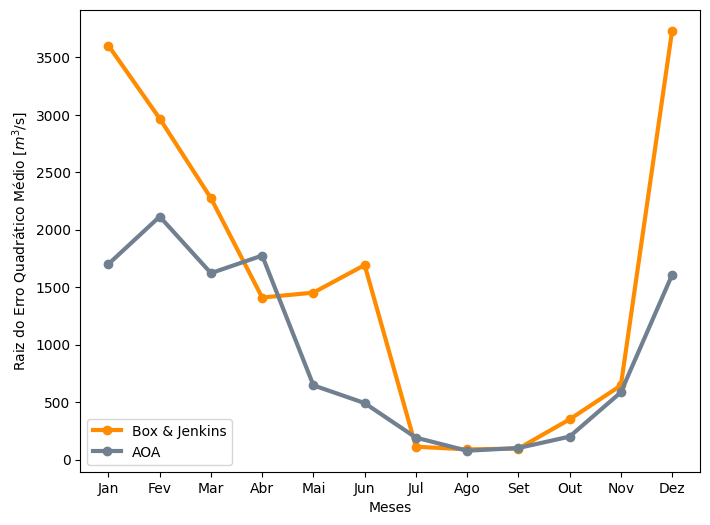

In [ ]:
fig,axis = plt.subplots(figsize=(8,6))

axis.plot([imes[0:3] for imes in meses],media_erro_parp,lw=3.0,marker = 'o',color='darkorange',label='Box & Jenkins')
axis.plot([imes[0:3] for imes in meses],media_erro_AOA,lw=3.0,marker = 'o',color='slategrey',label='AOA')
axis.set_xlabel('Meses')
if Tipo=='REE':
  axis.set_ylabel('Raiz do Erro Quadrático Médio [MWmed]')
elif Tipo=='UHE':
  axis.set_ylabel('Raiz do Erro Quadrático Médio [$m^3$/s]')

axis.legend();
plt.savefig('erro_'+Tipo+'_'+Nome+'.pdf',bbox_inches='tight');

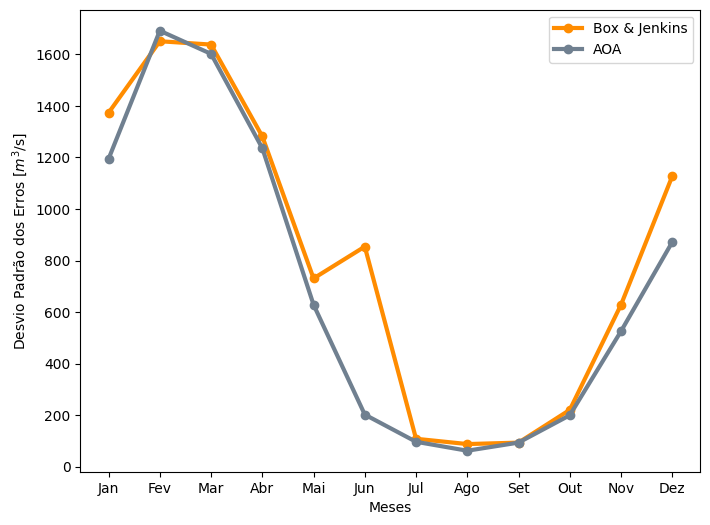

In [ ]:
fig,axis = plt.subplots(figsize=(8,6))

axis.plot([imes[0:3] for imes in meses],desvio_erro_parp,lw=3.0,marker = 'o',color='darkorange',label='Box & Jenkins')
axis.plot([imes[0:3] for imes in meses],desvio_erro_AOA,lw=3.0,marker = 'o',color='slategrey',label='AOA')
axis.set_xlabel('Meses')
if Tipo=='REE':
  axis.set_ylabel('Desvio Padrão dos Erros [MWmed]')
elif Tipo=='UHE':
  axis.set_ylabel('Desvio Padrão dos Erros [$m^3$/s]')

axis.legend();
plt.savefig('desvio_'+Tipo+'_'+Nome+'.pdf',bbox_inches='tight');

### Ordem

In [ ]:
ordem_parp = [solucao_parp[0][imes]['Ordem'] for imes in meses]
ordem_AOA = [solucao_AOA[0][imes]['Ordem'] for imes in meses]

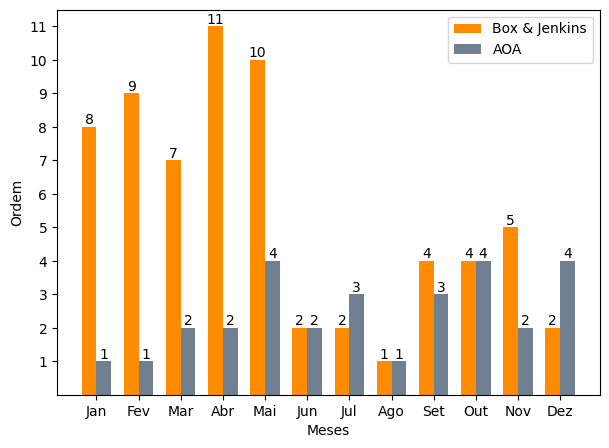

In [ ]:
# Dados de exemplo
labels = [mes[0:3] for mes in meses]
values1 = ordem_parp
values2 = ordem_AOA

# Posição das barras no eixo x
x = np.arange(len(labels))

# Largura das barras
width = 0.35

# Criando o gráfico de barras
fig, axis = plt.subplots(figsize=(7, 5))

# Plotando o primeiro conjunto de barras
bars1 = axis.bar(x - width/2, values1, width, label='Box & Jenkins', color='darkorange')

# Plotando o segundo conjunto de barras
bars2 = axis.bar(x + width/2, values2, width, label='AOA', color='slategrey')

# Adicionando rótulos nas barras
axis.bar_label(bars1, fontsize=10)
axis.bar_label(bars2, fontsize=10)

# Adicionando rótulos nos eixos e título
axis.set_ylabel('Ordem')
axis.set_xlabel('Meses')
axis.set_xticks(x)
axis.set_yticks(np.linspace(1,11,11))
axis.set_xticklabels(labels)
axis.set_ylim([0,11.5])
axis.legend();

# Mostrando o gráfico
plt.savefig('ordem_'+Tipo+'_'+Nome+'.pdf',bbox_inches='tight');
plt.show();

## Série Negativa

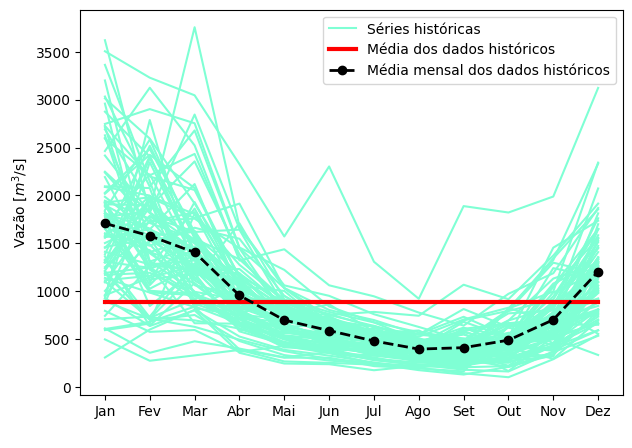

In [ ]:
if Tipo=='REE':

  dados = casoestudo.ree.get(Nome)

  media_dos_dados = np.mean(dados['ena_bruta'][0][0:12,1932-1931:2022-1931+1])*np.ones((12))
  desvio_dos_dados = np.std(dados['ena_bruta'][0][0:12,1932-1931:2022-1931+1])*np.ones((12))

  media_mes = [np.mean(dados['ena_bruta'][0][imes,1932-1931:2022-1931+1]) for imes in range(0,12)]

  xlabel = [mes[0:3] for mes in meses]

  fig,axis = plt.subplots(figsize=(7,5))

  for ihist in range(1932-1931,2022-1931+1):

    if ihist==1:

      axis.plot(xlabel,np.transpose(dados['ena_bruta'][0])[ihist,0:12],color='aquamarine',label='Séries históricas');

    else:

      axis.plot(xlabel,np.transpose(dados['ena_bruta'][0])[ihist,0:12],color='aquamarine');

  axis.plot(xlabel,media_dos_dados,color='red',lw=3.0,label = 'Média dos dados históricos');
  axis.plot(xlabel,media_mes,color='black',ls = '--',marker='o',lw=2.0,label = 'Média mensal dos dados históricos');
  axis.set_xlabel('Meses');
  axis.set_ylabel('Energia Natural Afluente [MWmed]');
  axis.legend();

  plt.savefig('serie_negativa_'+Tipo+'_'+Nome+'.pdf',bbox_inches='tight');

elif Tipo=='UHE':

  dados = casoestudo.confhd.get(Nome)

  media_dos_dados = np.mean(dados['vazoes'][1932-1931:2022-1931+1,0:12])*np.ones((12))

  media_mes = [np.mean(dados['vazoes'][1932-1931:2022-1931+1,imes]) for imes in range(0,12)]

  xlabel = [mes[0:3] for mes in meses]

  fig,axis = plt.subplots(figsize=(7,5))

  for ihist in range(1932-1931,2022-1931+1):

    if ihist==1:

      axis.plot(xlabel,dados['vazoes'][ihist,0:12],color='aquamarine',label='Séries históricas');

    else:

      axis.plot(xlabel,dados['vazoes'][ihist,0:12],color='aquamarine');

  axis.plot(xlabel,media_dos_dados,color='red',lw=3.0,label = 'Média dos dados históricos');
  axis.plot(xlabel,media_mes,color='black',ls = '--',marker='o',lw=2.0,label = 'Média mensal dos dados históricos');
  axis.set_xlabel('Meses');
  axis.set_ylabel('Vazão [$m^3$/s]');
  axis.legend();

  plt.savefig('serie_negativa_'+Tipo+'_'+Nome+'.pdf',bbox_inches='tight');